In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_profiling 
from pandas_profiling import ProfileReport
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as seabornInstance 
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
dataset = pd.read_csv('salary.csv')
display(dataset)


,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...
509,45906.0,6,17,11,0.92,1,0,2,0,2,70
510,60402.0,6,19,7,0.86,1,0,3,0,1,72
511,53187.0,19,7,6,0.78,1,0,3,0,4,76
512,56542.0,8,20,10,0.78,1,0,3,0,2,78


In [3]:
descr = pd.read_csv('Salary_metadata.csv', sep=';')
display(descr)

,Variable,Type,Explanation
0,salary,Continuous,Annual salary in dollars
1,exprior,Continuous,Years of experience prior to working in this f...
2,yearsworked,Continuous,Years worked in this field
3,yearsrank,Continuous,Years worked at current rank
4,market,Continuous,Market value (1 = salary at market value for p...
5,degree,Binary,"Has degree (0 = no, 1 = yes)"
6,otherqual,Binary,Has other post-secondary qualification (0 = no...
7,position,Categorical,"Position (1 = Junior Employee, 2 = Manager, 3 ..."
8,male,Binary,"0 = no, 1 = yes"
9,Field,Categorical,"Field of work (1 = Engineering, 2 = Finance, 3..."


In [4]:
# - Renaming column variable for better understanding and for clarity

# -  Gender -
dataset.rename(columns={'male': 'gender'},inplace=True)

# - Variables - 
dataset.replace({'gender':{0:'Female',1:'Male'}}, inplace=True)


### Exploratory Data Analys (EDA) 

In [5]:
ProfileReport(dataset)

In [6]:
dataset = dataset.dropna()
dataset.isnull().sum()


salary         0
exprior        0
yearsworked    0
yearsrank      0
market         0
degree         0
otherqual      0
position       0
gender         0
Field          0
yearsabs       0
dtype: int64

#### Question 1

On our dataset we had 514 people that where observed with one column containing missing infomation, 386 were Males and 128 were Females


We can use years worked, years rank,position and market as variables to predict salary because there is a positive linear relationship between them when compared to salary

The yearsabs column would need to be transformed because it is not consistant and is not captured correctly. We would need to change the column to days absent or convert the yearabs to days absent because no one can be absent for 60 years at work it does not make any sense

### Features Engineering

In [14]:
dataset.replace({'Field':{1:'Engineering',2:'Finance',3:'Human Resources',4:'Marketing'}}, inplace=True)
dummies = pd.get_dummies(dataset.Field)

In [15]:
merged = pd.concat([dataset,dummies],axis=1)
remove = ['Field','Human Resources']
df = merged[merged.columns.difference(remove)]

#### Correlation and Statistical Significance Analysis

#### Question 3

In [16]:
# - Pearson correlation coeffificent and the correspnding correlation matrix

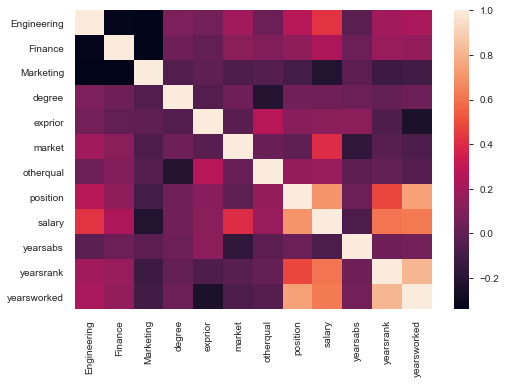

In [17]:
corr  =  df.corr()
sns.heatmap(corr)

#####  P-values related to the Pearson correlation coeffificents

In [38]:
from scipy import stats
# P-Value and varience
print(f'p-values between years-worked and salary: {stats.pearsonr(merged.salary, merged.yearsworked)}')
print(f'p-values between years-rank and salary: {stats.pearsonr(merged.salary, merged.yearsrank)}')
print(f'p-values between postion and salary: {stats.pearsonr(merged.salary, merged.position)}')

p-values between years-worked and salary: (0.6235888657598049, 1.2873351342915672e-56)
p-values between years-rank and salary: (0.6107063176375227, 9.307173080331551e-54)
p-values between postion and salary: (0.7021217379212223, 2.1640014953111997e-77)


###### Multicollinearity

In [39]:
df.head(0)

,Engineering,Finance,Marketing,degree,exprior,gender,market,otherqual,position,salary,yearsabs,yearsrank,yearsworked


In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
merged['salary'] # dependent variable
X = df.drop(['salary','exprior','otherqual','degree','exprior','gender','market','yearsabs'], axis=1)

vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['feature'] = X.columns
display(vif)

,VIF Factor,feature
0,2.278273,Engineering
1,2.128060,Finance
2,1.864045,Marketing
3,9.886126,position
4,7.075782,yearsrank
5,14.194886,yearsworked


#### Feature Selection

For feature selection i used the Embedded method. The Embedded method is iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

In [41]:
y = merged['salary']
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 74.583323
Best score using built-in LassoCV: 0.696799


In [42]:
print("Lasso picked  all" + str(sum(coef != 0)) + " and didnt elimenate variable")

Lasso picked  all6 and didnt elimenate variable


Text(0.5, 1.0, 'Feature importance using Lasso Model')

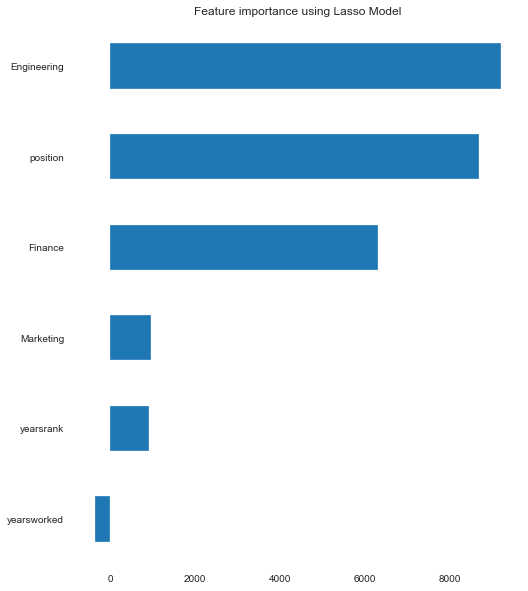

In [43]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [44]:
# -  Splitting data
X = df.drop(['salary','exprior','otherqual','degree','exprior','gender','market','yearsabs'], axis=1)
y = merged['salary']
y_pred = linreg.predict(X_test)

### Question 6 Train model:

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [46]:
model = sm.OLS(y_train,X_train).fit()
predictions = model.predict(X_test)

In [47]:
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 salary   R-squared (uncentered):                   0.959
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              1560.
Date:                Tue, 12 May 2020   Prob (F-statistic):                   7.17e-276
Time:                        07:44:26   Log-Likelihood:                         -4382.3
No. Observations:                 410   AIC:                                      8777.
Df Residuals:                     404   BIC:                                      8801.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Engineering  1.406e+04   1644.932      8.547      0.000    1.08e+04    1.73e+04
Finance        1.1e+04   1602.559      6.865      0.000    7850.656    1.42e+04
Marketing    9800.5702   1391.281      7.044      0.000    7065.517    1.25e+04
position     2.057e+04    724.612     28.381      0.000    1.91e+04     2.2e+04
yearsrank    1400.4183    147.725      9.480      0.000    1110.012    1690.825
yearsworked -1084.7922    124.320     -8.726      0.000   -1329.187    -840.398
==============================================================================
Omnibus:                        5.194   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                5.291
Skew:                           0.262   Prob(JB):                       0.0710
Kurtosis:                       2.812   Cond. No.                         78.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# - interpretation of standardised coefficients given in the statsmodels output.


In [49]:
# - What are the most important features when predicting employee salary?


##### Evaluate model


In [59]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

NameError: name 'y_pred' is not defined